# 190903 sobel pooling

## ideas
- [ ] 
      1. 根据超模糊色块(可以说saliency map)确定初始观察点(们), 然后扩散着去找线条(或梯度sobel)高于阈值的像素位置, 去给像素两侧打label;
      2. 现在是给点(pixel距离为1), 后面可以拓展到pixel距离为10, 100的情况, 来避免渐变的问题;
      3. 其实阈值应当由高0.95倍而低0.05倍, 这样符合由粗而细的直觉;
- [ ] 一种图卷积, 第一层以3\*3的kernel为基础(其实3\*3好的原因其实是因为它有明确的方向侧重), 通过一部分10几个手工设计的filter(包括坐标, canny, sobel, laplace, fft, gradient等)+ 自优化的filters来提取3\*3小范围特征, relu激活, 然后重复两三层, 后面就开始更大范围的扫街, 比如11\*11的核内分8个方向, 每个方向relu_pool一个最大的响应, 得到其位置, 计算距离中心的位置, 8个位置的比例可以用来当做特征, 特定模型的参数会跟与之对应的特征产生最大共鸣响应
- [ ] 类内与类外的较量, 类的凝聚力, 类内元素的不合群力(觉得自己与其他成员不同), 与法律的约束力(离群会带来强烈惩罚)之间的较量, 对于每个个体来说, 它同时评估各个声索方及转换成本(计算力充足的情况下应为0, 但为了节省算力而设置一个门槛)的score, 决定归属谁
- [ ] 特征数量不匹配是造成识别困难的巨大阻碍，从这些特征中筛选关键特征很重要，不如让这些特征竞争，只给5到10个特征槽位，让这些特征竞争它们的特征重要度，从而方便比较与识别，具体环境再加载具体的特征槽位，就像RPN一样，搞一个网络来确定槽位场景
- [ ] 用数据结构模拟CNN卷积的过程,先试着重现, 核心的问题是针对pooling的格子必选问题, 改为区域最大, 从而不漏掉局部最优, 也不多加局部最优进来, 但是卷积核的参数BP要好好想想
- [ ] 对于一张图(可以是灰度图), 找出各个通道(rgblab)在局部的变化最强的点(一阶导数为0)、当前色彩变化的极值点(最亮或最暗,二阶导数为0)
    - 可能不是方差，而是3*3 5*5的一阶二阶梯度来表达光滑与粗糙的概念，梯度方向的局部一致度的方差倒是一个利器来提取边界和曲线，至少是判断是否值得搞提取线条的依据
    - 现有的方法把梯度正交方向的值加起来了，不合理，应当分通道处理，一个有意思的处理应当是找到一对正交的梯度对，它们所表达的梯度相对x方向的角度是特征，讲道理一个强响应，一个弱为0的话，只保留那个强响应的也就够了，回头把目前weight所表达的梯度方向打印一下看一看
- [ ] 使用RL(DDPG)来选择channel, 选出来的顺序按照1/2,1/4,1/8,1/8的类似指数衰减的加权来组合, 选的时候用编码器,但应该是循环编码之类的编码
- [ ] 针对SLIC的情况,模拟CNN的滑窗, 从细到粗给出聚类, top一层使用旗下的众数的top3作为自己的特征, 进一步聚类, 一个点对多个周边的簇打分, 取分最高的
- [ ] 有编号的空间位置(0～1或给定了最大wh)和有序的通道，有了远近概念后，适当的平方层也要有。考虑单层fine tune block
- [ ] 学会使用图像语言来表达异同，对于同类的，就应该把中心的像素的值拿来当做自己的特征之一，觉得相近的，在一定阈值或者或者几个限定之内的前几相似的像素都应该拿来当做自己的特征，以有意义地表达近的概念。这样做主要是因为图像当中似乎没有明确表达坐标的概念，当然也可以反过来搞出一个明确表达坐标的表示法
- [ ] channel之间,或者卷积核之间的施密特正交化
- [ ] 这个xception有点EM的意思, 可以考虑使用EM给他表示, 打印展示, 甚至改进[9.30]
- [ ] 关于xception的神奇疗效, 关于如何在更好处理pooling和stride各自带来的问题,考虑一种在最大,最小,第二大,第二小池上使用4入1出1\*1卷积加权的做法, 都有评价参数,但只有一个参与运算
- [ ] 卷积是怎么评价"这个特征图的这个地方跟那个啥有多像"这个问题的, 猜是卷积核的样子,比如说连续几层的卷积层的filter的组合
- [ ] 使用色彩, erosion dilation, 简化图像信息, 优化颜色位置编码
- [ ] 使用cycle gan生成mask的auto code, 使用drl解释code
- [ ] mask rcnn的结果进行ppo, roialign或rpn之后的特征处开始训练actor critic, 看看最终能不能帮助改善rcnn, 主要是为了提高iou
- [ ] 球坐标经纬度范围加zoom信息及其归一化与置信度，经纬度上的高斯，随时间方差增大
- [ ] region proposal with hsv 记录邻域, 宽阈值筛选， 然后再精细化阈值， 辨认脸型
- [ ] 图像的小片方差也有它的边缘信息, 即, 两个预处理, LAB转换和方差map

## 今日任务
- [ ] 测试lookaround
- [ ] 整合进super pixel

In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(1, '/home/xianr/TurboRuns/msiip')
from dataloaders.datasets import cityscapes
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from dataloaders.utils import decode_seg_map_sequence

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

class FakeArgs():
    pass
args = FakeArgs()
args.workers = 0
# args.workers = 1
args.dataset = 'cityscapes'
args.batch_size = 4
# args.batch_size = 1
args.base_size = 513
args.crop_size = 513
args.cuda = False

kwargs = {'num_workers': args.workers, 'pin_memory': True}
train_set = cityscapes.CityscapesSegmentation(args, split='train')

Found 2975 train images


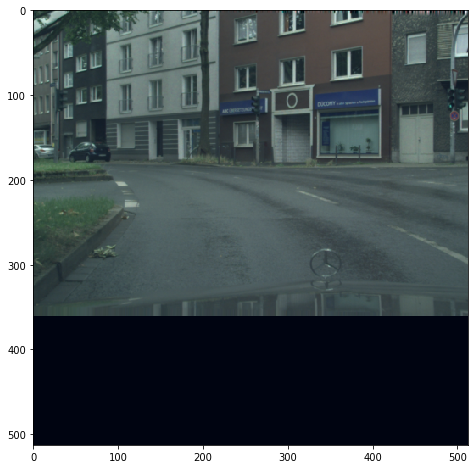

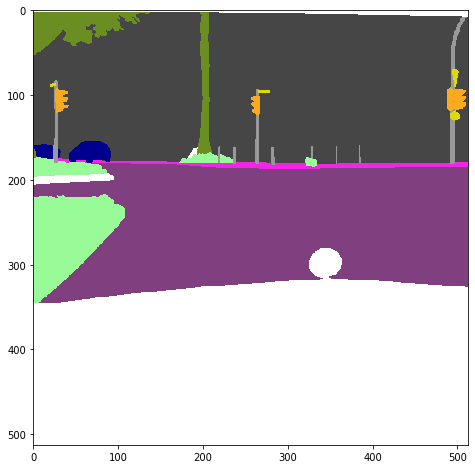

In [2]:
# image, target = train_set[10]
sample = train_set[2222]
image, target = sample['image'].unsqueeze(0), sample['label'].unsqueeze(0)

def show_color_img_tensor(img):
    plt.figure(figsize = (12,8))
    color_img = img.permute(1,2,0).detach().cpu()
    color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
    plt.imshow(color_img)

def show_color_img(img):
    plt.figure(figsize = (12,8))
    plt.imshow(img)
    
    
show_color_img_tensor(image[0])

from dataloaders.utils import decode_segmap
target_segmap = decode_segmap(target[0].detach().cpu().numpy(), dataset='cityscapes')
show_color_img(target_segmap)

Found 2975 train images
Found 500 val images
744 125


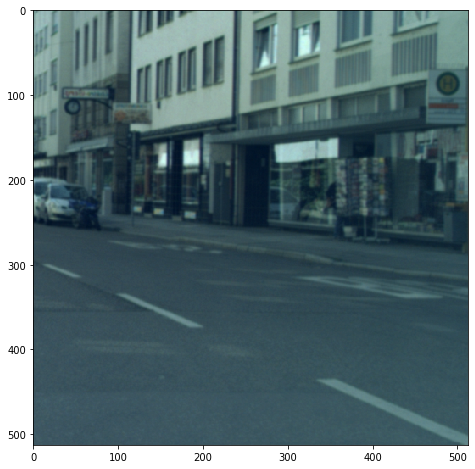

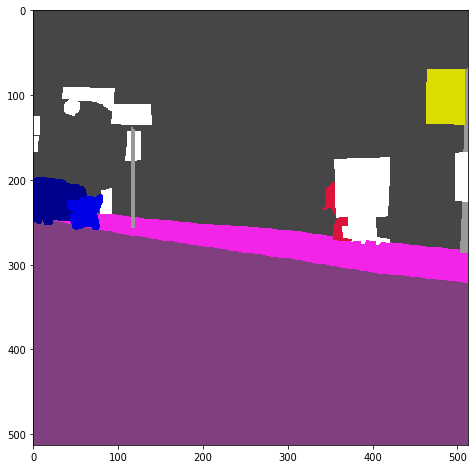

In [3]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(1, '/home/xianr/TurboRuns/msiip')
from dataloaders.datasets import cityscapes
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from dataloaders.utils import decode_seg_map_sequence

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

class FakeArgs():
    pass
args = FakeArgs()
args.workers = 0
# args.workers = 1
args.dataset = 'cityscapes'
args.batch_size = 4
# args.batch_size = 1
args.base_size = 513
args.crop_size = 513
args.cuda = False

kwargs = {'num_workers': args.workers, 'pin_memory': True}
train_set = cityscapes.CityscapesSegmentation(args, split='train')
val_set = cityscapes.CityscapesSegmentation(args, split='val')
num_class = train_set.NUM_CLASSES
train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, **kwargs)
val_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, **kwargs)
print(len(train_loader), len(val_loader))

sample = next(iter(train_loader))
image, target = sample['image'], sample['label']
# image, target = image.cuda(), target.cuda()

def show_color_img_tensor(img):
    plt.figure(figsize = (12,8))
    color_img = img.permute(1,2,0).detach().cpu()
    color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
    plt.imshow(color_img)

def show_color_img(img):
    plt.figure(figsize = (12,8))
    plt.imshow(img)
    
def show_color_img_01(img):
    plt.figure(figsize = (12,8))
    img = (img - img.min())/(img.max() - img.min())
    plt.imshow(img)
    
show_color_img_tensor(image[0])

from dataloaders.utils import decode_segmap
target_segmap = decode_segmap(target[0].detach().cpu().numpy(), dataset='cityscapes')
show_color_img(target_segmap)

In [4]:
# from multiscaleinit.msismpdsuperpixel import MultiScaleInitShareMiddle
from multiscaleinit.msismpyrimiddecode import MultiScaleInitShareMiddle
model = MultiScaleInitShareMiddle(num_classes=num_class)
# model = model.cuda()

args.load_weights = '/home/xianr/TurboRuns/msiip/run/cityscapes/msi-sm-pyrimid-decode/experiment_3/checkpoint.pth.tar'
state_dict = torch.load(args.load_weights)['state_dict']
model.load_state_dict(state_dict)

<All keys matched successfully>

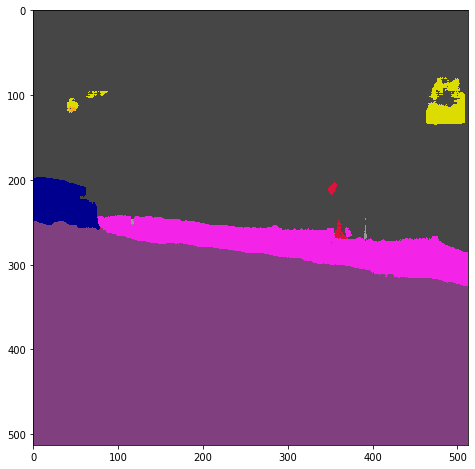

In [5]:
output = model(image)
out_segmap = decode_segmap(torch.max(output[0], 0)[1].detach().cpu().numpy(), dataset='cityscapes')
show_color_img(out_segmap)

In [6]:
from skimage.segmentation import slic,mark_boundaries

In [7]:
img = image.numpy().astype(np.float64)[0].transpose((1,2,0))

In [8]:
segments = slic(img, n_segments=600, compactness=10)

In [9]:
out=mark_boundaries(img,segments)

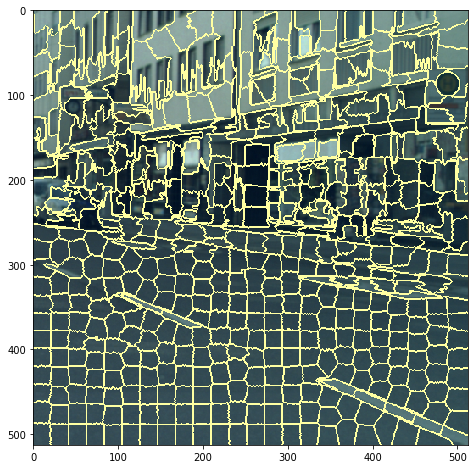

In [10]:
show_color_img_01(out)

In [11]:
segments.shape

(513, 513)

In [12]:
segments

array([[  0,   0,   0, ...,  22,  22,  22],
       [  0,   0,   0, ...,  22,  22,  22],
       [  0,   0,   0, ...,  22,  22,  22],
       ...,
       [474, 474, 474, ..., 492, 492, 492],
       [474, 474, 474, ..., 492, 492, 492],
       [474, 474, 474, ..., 492, 492, 492]])

In [13]:
segments.max()

493

In [15]:
target.shape

torch.Size([4, 513, 513])

In [16]:
segments.shape

(513, 513)

In [17]:
target_segmap.shape

(513, 513, 3)

In [18]:
target_out=mark_boundaries(target_segmap,segments)

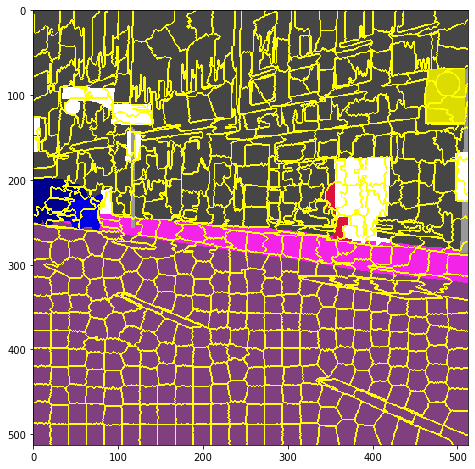

In [19]:
show_color_img_01(target_out)

In [20]:
60*60*60*60

12960000

In [ ]:
for i in range(600):
    np.where()

In [29]:
www=np.where(segments==11)

In [26]:
1/(957/513/513)

274.9937304075235

In [32]:
www[0].shape

(957,)

In [37]:
target[0][www].mode()

torch.return_types.mode(
values=tensor(2.),
indices=tensor(956))

In [39]:
target[0,www].shape

torch.Size([2, 957, 513])

In [40]:
for bt_i_target in target:
    www = np.where(segments==11)
    print(www.shape)

torch.Size([513, 513])
torch.Size([513, 513])
torch.Size([513, 513])
torch.Size([513, 513])
